# Reproducing the Results from the Paper: *Heisenberg-Limited Ground-State Energy Estimation for Early Fault-Tolerant Quantum Computers*

___

## Key Idea:

Let $\rho$ be a good initial guess for the ground state wave function (a wavefunction with a good initial overlap) of a Hamiltonian of interest of interest $H$. Then, one can define a spectral measure of $\tau H$ associated with $\rho$ (where $\tau \in  \mathbb{R}$ is chosen to normalize the Hamiltonian), and a CDF associated with it such that

$$
C(x) = \sum_{k: \lambda_k \leq x} p_k 

$$

where $p_k$ is the overlap between $\rho$ and the $k^{th}$ eigenvalue $\lambda_k$ of $H$. Consequently, **if one could calculate $C(x)$, it would be possible to find the ground state eigenvalue $\lambda_0$ beacuse each jump of this CDF happen at a correspopnding eigenvalue.**


**This algorithm consists of stochastically approximating the CDF $\hat{C}(x)$ by sampling from a quantum circuit that performs the Hadamard test on $e^{-i j \tau H}$, where $j$ is a random variable.**


## Description of the Algorithm:

To approximate the $\hat{C}(x)$, they first define an approximate Heaviside function $F(x) = \sum_{|j|\leq d} \hat{F_j}e^{ijx}$ (more details are provided later on in the implementation). Then, after some mathematical treatment, they define

$$
\hat{C}(x) = \sum_{|j|\leq d} \hat{F_j}e^{ijx} Tr[\rho e^{-ij\tau H}]
$$

### Hadamard Test (Quantum Subroutine)

Now, with the Hadamard test we can use a quantum computer to evaluate $Tr[\rho e^{-ij\tau H}]$ as follows:

Consider the following circuit

![circuit](circuit.png)

Let $W = I$ and let $X_j$ be a random variable such that

$$
X_j =
\begin{cases}
1  \text{ if the ancilla register is 0},\\
-1 \text{ if the ancilla register is 1}\\
\end{cases}
$$

Similarly, let $W = S^\dag$ (where $S$ is known as the phase gate) and let $Y_j$ be a random variable such that

$$
Y_j =
\begin{cases}
1  \text{ if the ancilla register is 0},\\
-1 \text{ if the ancilla register is 1}\\
\end{cases}
$$


It can then be shown that

$$ 
E[X_j] =\text{Re} \, Tr[\rho e^{-ij\tau H}]
$$
$$ 
E[Y_j] = \text{Im} \, Tr[\rho e^{-ij\tau H}]
$$


For simplicity, the paper defines a random variable

$$
Z_j = X_j + i Y_j
$$

and thus we have 

$$
E[Z_j] = Tr[\rho e^{-ij\tau H}]
$$




### Stochastically evaluating $\hat{C}(x)$

To avoid evaluating all the terms of $\hat{C}(x)$, they propose a monte carlo inspired stochastic method to aprroximate this sum. 

Method:

Let $J$ be a random variable with support $\{-d, -d+1, ..., d\}$ and PMF 
$$
Pr[J=j] = \frac{|\hat{F_j}|}{\sum_{|j|\leq d} |\hat{F_j}|}
$$

They then show that 

$$
E[(X_J + i Y_J)e^{i(\theta_J + J x)}] = \frac{\hat{C}(x)}{\sum_{|j|\leq d} |\hat{F_j}|}
$$

and thus they define the unbiased estimator

$$
G(x;J,Z_J) = (\sum_{|j|\leq d} |\hat{F_j}|) * Z e^{i(\theta_J + J x)}
$$

Such that 

$$
\hat{C}(x) = E[G(x;J,Z_J)]
$$


# Implementing the Algorithm

1. Generate samples ${J_k}$
2. Generate samples ${Z_k}$ from a quantum circuit
3. Compute the estimator $G(x:J,Z)$ and estimate $\hat{C}(x)$

## Generating the $J_k$ samples


To generate the samples of $J_k$, we first need to construct the function $F(x)$. In the paper, they do so in the following way:

First, they define the following two functions

![mollifier](M_N_definitions.png)

and they plot them

![M_plots](fig5.png)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import rv_discrete 
from numpy import sqrt, sin, cos, pi, log
from numba import jit
from functools import lru_cache



### Building $F(x)$

In [7]:
# Implementing N(d,delta)
@lru_cache(maxsize=None)
def N(d, delta):
    
    chebyshev_argument = lambda x: 1 + 2*(cos(x)-cos(delta))/(1+cos(delta))

    chebyshev = lambda degree,x : special.eval_chebyt(degree, x)

    integrand = lambda x: chebyshev(d, chebyshev_argument(x))

    integral_value, _ = integrate.quad(integrand, -pi, pi)

    return integral_value

# @lru_cache(maxsize=None)
# def N_trial(d, delta):
#     chebyshev_argument = lambda x: 1 + 2 * (np.cos(x) - np.cos(delta)) / (1 + np.cos(delta))
#     # Using Gaussian quadrature to accurately integrate Chebyshev polynomials
#     nodes, weights = np.polynomial.chebyshev.chebgauss(d + 1)
#     chebyshev_values = special.eval_chebyt(d, chebyshev_argument(nodes))
#     integral_value = np.sum(chebyshev_values * weights)
#     return integral_value


# Implementing M(d,delta, x)
@lru_cache(maxsize=None)
def M(d, delta, x):

    chebyshev_argument = lambda n: 1 + 2*(cos(n)-cos(delta))/(1+cos(delta))

    chebyshev = lambda degree, m: special.eval_chebyt(degree, m)

    return chebyshev(d, chebyshev_argument(x))/N(d, delta)
    

# Looks good
M(20, 0.2, 0)

4.4560732736927395

In [10]:
%%time

M(int(2e4), 2e-4, 0)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


18.652255449622903

In [12]:
%%time

N(int(2e4), 2e-4)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


1.4640713559427685

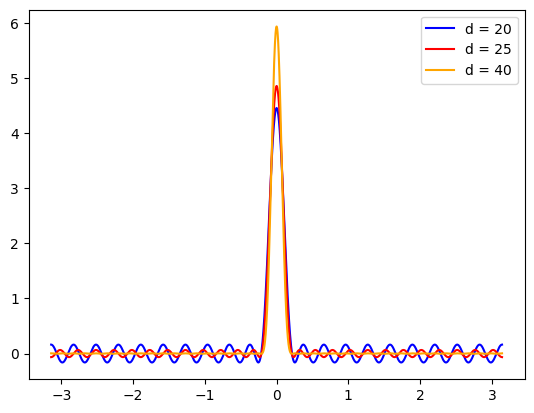

In [14]:
x = np.linspace(-pi, pi, 500000)

y = [M(20,0.2, i) for i in x]
plt.plot(x, y, color='blue', label = 'd = 20')

y = [M(25,0.2, i) for i in x]
plt.plot(x, y, color='red', label = 'd = 25')


y = [M(40,0.2, i) for i in x]
plt.plot(x, y, color='orange', label = 'd = 40')
# plt.plot(x, M(int(2e4),2e-4, x), color='skyblue', label = 'd = 2e4 | 2e-4')

plt.legend()

plt.show()

In [166]:
%%time

M(int(2e4),2e-4, 0.11)

CPU times: user 7 µs, sys: 27 µs, total: 34 µs
Wall time: 36 µs


0.4343960174061608

In [205]:
def M_fourier_fft(d, delta, k):

    k_discretized = np.linspace(-d, d, 100)

    M_discretized = M(d, delta, k_discretized)

    M_fourier_coefficients = np.fft.fft(M_discretized)

    return M_fourier_coefficients


M_fourier_fft(200, 0.02, 10)

array([-3.63117290e-01+0.00000000e+00j, -3.85823234e-01-1.21249836e-02j,
       -4.97186795e-01-3.12803417e-02j, -1.85682490e+00-1.75521630e-01j,
        1.71632862e+00+2.16822728e-01j,  1.38183936e-02+2.18861854e-03j,
       -1.12604435e-01-2.14804447e-02j, -1.88520117e-01-4.21392387e-02j,
       -2.80429286e-01-7.20020028e-02j, -4.66333046e-01-1.35482274e-01j,
       -1.28136430e+00-4.16340498e-01j, -5.17222125e-01-1.86211423e-01j,
        4.56287694e-01+1.80657078e-01j,  3.10027854e-01+1.34161032e-01j,
        2.68618230e-01+1.26402144e-01j,  2.90630866e-01+1.48083822e-01j,
        4.12157676e-01+2.26585600e-01j,  9.83427972e-01+5.81597681e-01j,
        3.45157745e-01+2.19043766e-01j, -6.41935708e-01-4.36259057e-01j,
       -4.40588905e-01-3.20106577e-01j, -3.89059941e-01-3.01785825e-01j,
       -4.03936768e-01-3.34165556e-01j, -5.00154944e-01-4.40945898e-01j,
       -8.89048084e-01-8.34871722e-01j, -4.17900917e-01-4.17900918e-01j,
        4.78711484e-01+5.09775953e-01j,  2.05395408

In [167]:
@lru_cache(maxsize=None)
def M_fourier(d, delta, k):
    integrand = lambda x: M(d, delta, x) * np.exp(-1j * k * x)

    integral_value, _ = integrate.quad(integrand, -pi, pi)

    return integral_value/sqrt(2*pi)
    

In [199]:
%%time

M_fourier(int(2e4),2e-4, 0.11)

CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 14.8 µs


0.3913372555371351

In [177]:
def H_fourier(k):
    if k%2 == 0:
        return 0
    else:
        return 2/(1j * k * sqrt(2*pi))

def F_fourier(d, delta, k):
    return sqrt(2*pi) * M_fourier(d, delta, k) * H_fourier(k)

In [348]:
F_fourier(20000, 0.0002, 1)


0.00711054233863192j

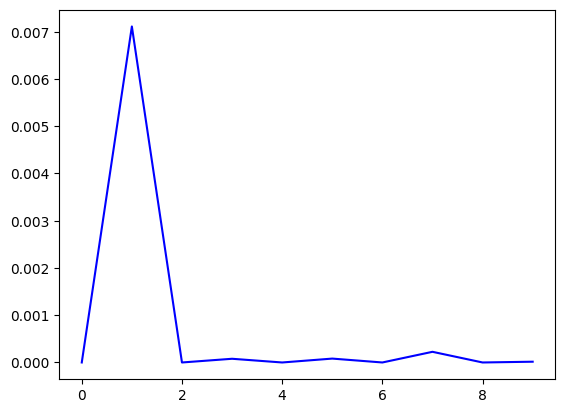

In [203]:

y = [F_fourier(20000, 0.0002, i) for i in range(10)]
plt.plot(np.abs(y), color='blue', label = 'd = 20')

In [225]:
# Calculating \theta_j

def get_theta(d, delta, k):

    F_k = F_fourier(d, delta, k)

    if F_k != 0:
        return F_k/np.abs(F_k)

    else:
        return 0
    
    return F_fourier(d, delta, k)/np.abs(F_fourier(d, delta, k))
    # return -1j * log(F_fourier(d, delta, k)/np.abs(F_fourier(d, delta, k)))


get_theta(2000, 0.002, 143)


1j

/Users/jorgegarciaponce/Research/Aspuru/Ground State Energy Estimation/venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/var/folders/2q/r_plhm951s93s5nlm_f8ymjr0000gn/T/ipykernel_1121/3294601285.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = integrate.quad(integrand, -pi, pi)
/var/folders/2q/r_plhm951s93s5nlm_f8ymjr0000gn/T/ipykernel_1121/3294601285.py:5: IntegrationWarning: The integral i

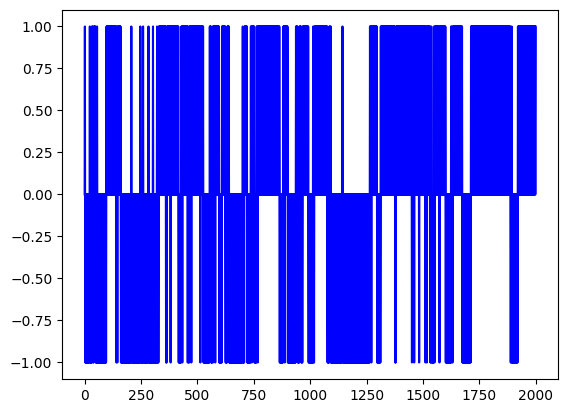

In [228]:

y = [get_theta(20000, 0.0002, i) for i in range(2000)]
plt.plot(np.imag(y), color='blue', label = 'd = 20')

### Sampling $J_k$

In [230]:
@lru_cache(maxsize=None)
def calculate_normalization_factor(d, delta):

    normalization_factor = 0

    for i in range(-d, d+1):

        normalization_factor += np.abs(F_fourier(d, delta, i))
    
    return normalization_factor


In [231]:
@lru_cache(maxsize=None)
def J_pmf(j, d, delta):

    normalization_factor = calculate_normalization_factor(d, delta)

    return  np.abs(F_fourier(d, delta, j))/normalization_factor



In [239]:
# Sanity check to make sure it is a valid pmf

total_p_sum = 0

for i in range(-int(2e3),int(2e3)+1):
    total_p_sum += J_pmf(i,int(2e3),2e-3)

print(total_p_sum)

/Users/jorgegarciaponce/Research/Aspuru/Ground State Energy Estimation/venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/var/folders/2q/r_plhm951s93s5nlm_f8ymjr0000gn/T/ipykernel_1121/3294601285.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_value, _ = integrate.quad(integrand, -pi, pi)
/var/folders/2q/r_plhm951s93s5nlm_f8ymjr0000gn/T/ipykernel_1121/3294601285.py:5: IntegrationWarning: The integral i

0.9999999999999989


In [240]:
def get_J_distribution(d, delta):

    support = range(-d, d+1)

    probabilities = [J_pmf(i, d, delta) for i in support]

    custom_distribution = rv_discrete(name = 'custom', values=(np.array(support), np.array(probabilities)))

    return custom_distribution


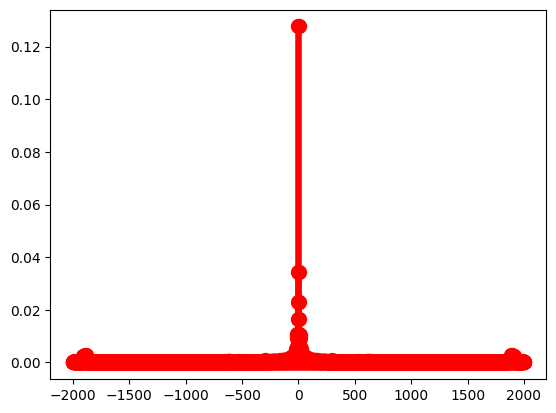

In [244]:
# Plotting the PMF
J_distribution = get_J_distribution(int(2e3), 2e-3)

fig, ax = plt.subplots(1, 1)
xk = [i for i in range(-int(2e3),int(2e3)+1)]
ax.plot(xk, J_distribution.pmf(xk), 'ro', ms=10, mec='r')
ax.vlines(xk, 0, J_distribution.pmf(xk), colors='r', lw=4)
plt.show()

In [249]:
# Hope this isn't wrong

J_pmf(1,int(2e3), 2e-3)

0.12767549059424602

In [251]:
# Sample from the distribution
num_samples = 100
samples = J_distribution.rvs(size=num_samples)

samples

tensor([  367,    -1,     1,     1,    35,   301,  -329,   571,    -1,
           -1,  1871,   109, -1889,   -13,  -389,   -13,     9,    -1,
         1047,   -27,     1,  -183,     1,    -1,  -239,     1, -1879,
            1,    -3,   101,    29,    13,   -23, -1793,  -379,     1,
            1,   -85,    57,    -1,   -77,   -33,   383,     1,   101,
          533,   -29,  -107,    43,     1,     1,    19,    11,     9,
            1,     3,     1,  1365,    -1,   -45,   -19,   -63,    -3,
            1,  -105,  -193,     1,     7,  -351,     1,   163,  -851,
            7,   -13,    -1,   449,    -7,  1091,     1,  -531,  -915,
            7,  1541,  1769,    97, -1723,   997,     7,    -1, -1755,
          295,  -243,   -39,     9,   121,   145,     1,   -27,     3,
           -1], requires_grad=True)

## Sampling $Z_k$ from the Quantum Circuit

Recall the circuit and the random variable definitions:

![circuit](circuit.png)

Let $W = I$ and let $X_j$ be a random variable such that

$$
X_j =
\begin{cases}
1  \text{ if the ancilla register is 0},\\
-1 \text{ if the ancilla register is 1}\\
\end{cases}
$$

Similarly, let $W = S^\dag$ (where $S$ is known as the phase gate) and let $Y_j$ be a random variable such that

$$
Y_j =
\begin{cases}
1  \text{ if the ancilla register is 0},\\
-1 \text{ if the ancilla register is 1}\\
\end{cases}
$$

### Fermi Hubbard Hamiltonian (Open Fermion)

In [252]:
# from scipy import sparse
from scipy.sparse import linalg
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from openfermion.utils import count_qubits

In [253]:
"""Define the Hamiltonian."""
# Parameters from the paper

nsites = 4
occupation_number = 2
U = 10.0

filled_sites = int(nsites/2) # Half filling

# Hopping Integral

# In the paper U/t = 4
t = U / 4

# Is the sign of the tunneling right?
fermionic_hamiltonian = fermi_hubbard(1, nsites, tunneling=-t, coulomb=U, periodic=False)

# Map to QubitOperator using the JW transform
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Convert to Scipy sparse matrix
hamiltonian_jw_sparse = get_sparse_operator(jw_hamiltonian)

# Compute ground energy
eigs, _ = linalg.eigsh(hamiltonian_jw_sparse, k=1, which="SA")
ground_energy = eigs[0]

print(f"Ground State Energy: {ground_energy}")
print("JWT transformed Hamiltonian:")
print(jw_hamiltonian)

jw_hamiltonian_qubits = count_qubits(jw_hamiltonian)
print(jw_hamiltonian_qubits)

# compute largest eigenvalue
hamiltonian_jw_sparse

max_hamiltonian_eigenvalue, _ = linalg.eigsh(hamiltonian_jw_sparse, k=1, which="LM")
print(max_hamiltonian_eigenvalue)



Ground State Energy: -6.562355678777147
JWT transformed Hamiltonian:
(10+0j) [] +
(1.25+0j) [X0 Z1 X2] +
(1.25+0j) [Y0 Z1 Y2] +
(-2.5+0j) [Z0] +
(2.5+0j) [Z0 Z1] +
(1.25+0j) [X1 Z2 X3] +
(1.25+0j) [Y1 Z2 Y3] +
(-2.5+0j) [Z1] +
(1.25+0j) [X2 Z3 X4] +
(1.25+0j) [Y2 Z3 Y4] +
(-2.5+0j) [Z2] +
(2.5+0j) [Z2 Z3] +
(1.25+0j) [X3 Z4 X5] +
(1.25+0j) [Y3 Z4 Y5] +
(-2.5+0j) [Z3] +
(1.25+0j) [X4 Z5 X6] +
(1.25+0j) [Y4 Z5 Y6] +
(-2.5+0j) [Z4] +
(2.5+0j) [Z4 Z5] +
(1.25+0j) [X5 Z6 X7] +
(1.25+0j) [Y5 Z6 Y7] +
(-2.5+0j) [Z5] +
(-2.5+0j) [Z6] +
(2.5+0j) [Z6 Z7] +
(-2.5+0j) [Z7]
8
[40.]


### Building the Circuit (Pennylane)

In [254]:
import pennylane as qml
from pennylane import numpy as np

In [255]:
def add_cnots(cnot_pairs):

    for pair in cnot_pairs:

        control, target = pair

        qml.CNOT([control, target])

def change_to_z_basis(pauli_string):

    for pauli_tuple in pauli_string:

        qubit = pauli_tuple[0]
        pauli = pauli_tuple[1]
        if pauli == 'X':
            qml.Hadamard(qubit)
        if pauli == 'Y':
            qml.RX(-np.pi/2, qubit)

def pauli_time_evolution(pauli_string, coefficient, time, control = -1):

    if len(pauli_string) == 0:
        return None
    
    # Getting the CNOT pairs
    target_qubit = pauli_string[-1][0]

    cnot_pairs = []

    for pauli_tuple in pauli_string:

        control_qubit = pauli_tuple[0]

        if control_qubit != target_qubit:
            cnot_pairs.append([control_qubit, target_qubit])


    ###### Applying the circuit

    # Changing basis
    change_to_z_basis(pauli_string)

    # qml.Barrier(only_visual=True)

    # Adding CNOT gates
    if len(cnot_pairs) > 0:
        add_cnots(cnot_pairs)

    # qml.Barrier(only_visual=True)

    # Adding the rotation gate
    theta = 2 * coefficient * time 

    if control != -1:
        qml.ctrl(qml.RZ, control)(theta, target_qubit)
    else:
        qml.RZ(theta, target_qubit)

    # qml.Barrier(only_visual=True)

    # Undoing CNOT gates
    if len(cnot_pairs) > 0:
        cnot_pairs.reverse()
        add_cnots(cnot_pairs)

    # qml.Barrier(only_visual=True)

    # Undoing change of basis
    change_to_z_basis(pauli_string)

    # qml.Barrier(only_visual=True)



In [256]:
def first_order_trotter_decomposition(qubit_hamiltonian, time, trotter_number, control = -1):

    dt = time/trotter_number

    for i in range(trotter_number): 

        for pauli_string, coefficient in qubit_hamiltonian.terms.items():

            pauli_time_evolution(pauli_string, coefficient, dt, control = control)



In [257]:
def prepare_hartree_fock_state():

    for i in range(occupation_number):
        qml.PauliX(i)


In [258]:
n_ancilla_qubits = 1

n_circuit_qubits = jw_hamiltonian_qubits + n_ancilla_qubits

@qml.qnode(qml.device('default.qubit', wires = n_circuit_qubits, shots = 1))
def circuit(time, trotter_number, imaginary):


    ancilla_wire = n_circuit_qubits - 1

    qml.Barrier(only_visual=True)

    prepare_hartree_fock_state()

    qml.Barrier(only_visual=True)

    qml.Hadamard(ancilla_wire)

    qml.Barrier(only_visual=True)

    first_order_trotter_decomposition(jw_hamiltonian, time, trotter_number, control=ancilla_wire)

    qml.Barrier(only_visual=True)

    if imaginary:
        qml.adjoint(qml.S(ancilla_wire))

    qml.Hadamard(ancilla_wire)

    return qml.sample(wires=ancilla_wire)



# print(qml.draw(pauli_exponential)(((0, 'X'), (2, 'Z'), (3, 'Y')), 1.25j, 2.3))

print(qml.draw(circuit)(1, 1, True))


0: ──||──X──||─────||──RX(-1.57)─╭●───────────────────────╭●──RX(-1.57)──H─╭●───────────────────
1: ──||──X──||─────||────────────│──╭●─────────────────╭●─│────────────────│──╭●────────────────
2: ──||─────||─────||──RX(-1.57)─╰X─╰X─╭RZ(2.50+0.00j)─╰X─╰X──RX(-1.57)──H─╰X─╰X─╭RZ(2.50+0.00j)
3: ──||─────||─────||──────────────────│─────────────────────────────────────────│──────────────
4: ──||─────||─────||──────────────────│─────────────────────────────────────────│──────────────
5: ──||─────||─────||──────────────────│─────────────────────────────────────────│──────────────
6: ──||─────||─────||──────────────────│─────────────────────────────────────────│──────────────
7: ──||─────||─────||──────────────────│─────────────────────────────────────────│──────────────
8: ──||─────||──H──||──────────────────╰●────────────────────────────────────────╰●─────────────

─────────────╭●──H─────────────────────────────────────────────────────────────────────────────────
──╭●─────────│───RX(-1.57)

In [259]:
def generate_Y(j, tau):

    trotter_number = 1

    total_time = j * tau

    circuit_result = circuit(total_time, trotter_number, True)

    if circuit_result == 1: 
        return -1
    if circuit_result == 0:
        return 1

generate_Y(1,1)

1

In [260]:
def generate_X(j, tau):

    trotter_number = 1

    total_time = j * tau

    circuit_result = circuit(total_time, trotter_number, False)

    if circuit_result == 1: 
        return -1
    if circuit_result == 0:
        return 1

generate_X(1,1)

1

In [261]:
def generate_Z(j, tau):

    X = generate_X(j, tau)
    Y = generate_Y(j, tau)

    return X + 1j * Y

generate_Z(1,1)

(1+1j)

## Calculating the unbiased estimator $G(x; J,Z)$

In [296]:
d = int(2e3)
delta = 2e-3

J_distribution = get_J_distribution(d, delta)

In [339]:
def G(x, J, d, delta, tau):

    F = calculate_normalization_factor(d, delta)

    Z = generate_Z(J, tau)

    exponential_theta = get_theta(d, delta, J)

    return F*Z*np.exp(1j*J*x)*exponential_theta

tau = pi/(4/pi*max_hamiltonian_eigenvalue)

G(0.1, 1, d, delta, tau)


(8.779070904004417-7.17802129116481j)

In [351]:
def estimate_cdf(x, d, delta, tau, n_samples):

    J_samples = np.real(J_distribution.rvs(size=n_samples))

    G_samples = []

    for k in range(n_samples):

        j_k = J_samples[k]
        # print(j_k)

        g_k = G(x, float(j_k), d, delta, tau)
        # print(g_k)

        G_samples.append(g_k)
    

    G_samples = np.array(G_samples)

    return np.mean(G_samples)

In [341]:
J_samples = J_distribution.rvs(size=100)
J_samples

tensor([ -641,     1,    -1, -1881,    -1,     1,  1041,   -39,  1671,
           -7,     1,     7,     5,    15,    -9,     7,    -1,   -75,
           25,    -3,   -23,    -7,    -7,  1911,  1885,    -3,  1863,
          -19,  -395,    -5,    -1,     1,    -1,     1,    -7,    91,
         -679,    -7,   -31,   -23,     1,  1993,   -69,   -11,     5,
        -1677,     3,    -1,   -31,    21,   397,    49,     3,   -93,
            1,   227,    -1,  -189,    29,  1895,    29,    13,  -425,
            3,   -17,    -9,   103,     1,    39,    -1,     1,   187,
            1,  -923,     1, -1539,   -89,    53,  1663,  -785,   -77,
           -3, -1345,     1,   -93,    13,    -7,     1,    11,     7,
          -11,     1,     3,   321,    -1,  1025,   -45,  -905,     1,
          161], requires_grad=True)

In [354]:
x_array = np.linspace(-pi/3, pi/3, 1000)

estimate_cdf(0, d, delta, tau, 3000)

tensor(-0.18175506+0.19779227j, requires_grad=True)